### Imports

In [43]:
import pandas as pd
import matplotlib
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from nltk.stem.porter import PorterStemmer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import requests
import json
import time
import numpy as np
import string
from collections import Counter

from bs4 import BeautifulSoup

import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/eksdee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eksdee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eksdee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Read business data

In [6]:
business = pd.read_json('business.json', lines=True)

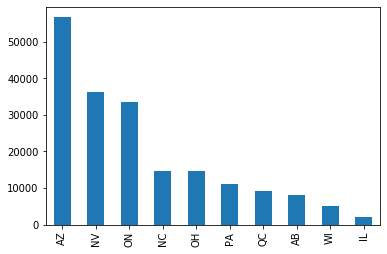

In [7]:
business.state.value_counts()[0:10].plot(kind='bar')

In [8]:
state_business = business[business.state == 'OH']

In [9]:
# Keep only business that are still open
# 1 = open, 0 = closed
# Drop columns that may not be relavent
state_business = state_business[state_business['is_open']==1].drop(['hours','is_open','review_count','latitude','longitude','attributes'], axis=1)

In [10]:
# Keep only business with categories that are food related
business_res = state_business[state_business['categories'].str.contains(
              'Restaurants',
              case=False, na=False)]

In [11]:
business_res_ids = pd.DataFrame(business_res.business_id)

In [12]:
business_res

,business_id,name,address,city,state,postal_code,stars,categories
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,4.0,"Italian, Restaurants, Pizza, Chicken Wings"
113,7aLkFEBnL1LJmQdcuaovuQ,Ohio Beer Garden,402 Great Northern Blvd,North Olmsted,OH,44070,4.0,"Restaurants, Pubs, Bars, Nightlife, American (..."
120,0lFAD4CuWcQVl9u3-lRaCQ,Cruisers Bar and Grill,6625 Dean Memorial Pkwy,Hudson,OH,44236,3.5,"Pubs, Restaurants, Bars, Event Planning & Serv..."
226,OwXMxqxIy4YoprAjnoUoiA,B & M Bar-B-Que Shaw,12700 Shaw Ave,Cleveland,OH,44108,3.5,"Barbeque, Restaurants"
243,U3-kxz7NWq4ix4bPmKKQ0w,Aladdin's Eatery,8870 Mentor Ave,Mentor,OH,44060,4.5,"Ethnic Food, Specialty Food, Food, Restaurants..."
...,...,...,...,...,...,...,...,...
192407,soQEl35sQuARBOlH1Y6MaQ,Teresa's Pizza,6010 Mayfield Rd,Cleveland,OH,44124,3.5,"Restaurants, Pizza"
192439,Ylm9cM4xIFgg6LLBr8Euow,Cuisine Express At Valero,6177 Pearl Rd,Cleveland,OH,44130,3.5,"Sandwiches, Restaurants"
192477,2JsLzYF8rUalwpm5LDEcog,Chowder House Cafe,2028 Chestnut Blvd,Cuyahoga Falls,OH,44223,3.5,"Seafood, Soup, Restaurants"
192589,ghovD5ZTGDQ5Q2U4ERddWw,Five Guys,3863 Medina Rd,Fairlawn,OH,44333,4.0,"Burgers, Restaurants, Fast Food, American (New)"


### Read Review data

In [13]:
review = pd.read_json('review.json', lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':float,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=100000)

### Merge Data

In [14]:
temp = []
for i in review:
    # Renaming column name to avoid conflict with business overall star rating
    i = i.rename(columns={'stars': 'review_stars'})
    temp.append(business_res_ids.merge(i, on='business_id', how='left'))
merged = pd.concat(temp)

In [15]:
state_business

,business_id,name,address,city,state,postal_code,stars,categories
9,4GBVPIYRvzGh4K4TkRQ_rw,Options Salon & Spa,21689 Lorain Rd,Fairview Park,OH,44126,4.5,"Beauty & Spas, Nail Salons, Day Spas, Massage"
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,4.0,"Italian, Restaurants, Pizza, Chicken Wings"
14,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,4145 Erie St,Willoughby,OH,44094,3.0,"Bakeries, Food"
40,-MsRvdPnuw6QuLn5Vxjruw,Brian's Furniture,30808 Center Ridge Rd,Westlake,OH,44145,5.0,"Shopping, Home Services, Interior Design, Rugs..."
56,YNvZdMLXa4q8e9tiE4ge4A,Louis Stokes Cleveland VA Medical Center,10701 E Blvd,Cleveland,OH,44106,3.5,"Health & Medical, Medical Centers"
...,...,...,...,...,...,...,...,...
192528,XMRultPt5xHJJXQzgceZzg,Tuesday Morning,6845 Pearl Rd,Middleburg Heights,OH,44130,3.5,"Outlet Stores, Discount Store, Shopping"
192555,gyGu3JEcWXvyiOAHmTHwbA,Tattoo Faction,30584 Lorain Rd,North Olmsted,OH,44070,4.5,"Tattoo, Beauty & Spas"
192589,ghovD5ZTGDQ5Q2U4ERddWw,Five Guys,3863 Medina Rd,Fairlawn,OH,44333,4.0,"Burgers, Restaurants, Fast Food, American (New)"
192594,NVSmNWDNYYZ82sdYID_9Tw,Verizon,4186 Kent Rd,Stow,OH,44224,1.0,"Electronics, Home Services, Professional Servi..."


In [16]:
merged.business_id.value_counts()

LNsZJP6jZ11e0tDljOLPiQ    1206
GIfZNMP0oIJCje_Xp0Bgrw    1110
J1RDyyPxhioqm8c_fi4P4Q    1083
JFaTPxWQC14VmFnXLv7W1g     965
meXjqyhTNLFmknY39y2sMg     953
                          ... 
sfWFdhpwsThk4w9nDg1tTA      67
gcr5J-7Ql2IzbK7JSYfUZw      67
oLz3JuHkQqwFcmOlwq__8A      67
PcpfOJhUC_dFFVG1o7waDw      67
SIGb2Q6PuoixOR4VtwgpgA      67
Name: business_id, Length: 4209, dtype: int64

In [17]:
merged

,business_id,review_id,user_id,review_stars,useful,funny,cool,text,date
0,fweCYi8FmbJXHCqLnwuk8w,PnKm8y0thZ5ZdWhuOk7Opg,VJvQiGrmtFXAmswRRIWYYw,5.0,0.0,0.0,0.0,"Hands down, this is the best pizza place in Me...",2017-06-27 23:35:47
1,fweCYi8FmbJXHCqLnwuk8w,UkLxSPjJr1jpIjCtcKx7GA,2OmdTYQXXG2qVokHKnrMdQ,4.0,0.0,0.0,0.0,Haven't had anything but the steak and cheese ...,2016-03-18 14:16:25
2,7aLkFEBnL1LJmQdcuaovuQ,P0gS1b7yPJBfWuBJqRYSZQ,jc-DVxWCEn0xULBTWgsYnw,4.0,1.0,1.0,1.0,"Nice place.great beer selection, super nice st...",2017-01-15 03:41:30
3,7aLkFEBnL1LJmQdcuaovuQ,ipNzgKpje7eL9XC7jS8P0g,wNnkBAPmyZMETAmwYbKZUQ,3.0,1.0,0.0,0.0,"Atmosphere is very relaxed and chill, they off...",2016-11-24 01:51:15
4,0lFAD4CuWcQVl9u3-lRaCQ,em3NBHWiD_0CyngJl579Aw,kDJB55VTl7pxtqaosPdpyw,1.0,1.0,0.0,0.0,Sitting at the table right now. Have not even ...,2015-03-04 21:37:34
...,...,...,...,...,...,...,...,...,...
6446,ghovD5ZTGDQ5Q2U4ERddWw,VEUN28rzGmxOHEZJAteDiw,GY2zI1WWM0Ef4lTeF1z2mw,4.0,0.0,0.0,0.0,Great burgers. Hate that the only portion of f...,2011-10-22 01:23:10
6447,ghovD5ZTGDQ5Q2U4ERddWw,igJ6hjC3ETuQQYcYcxYc_g,08DZYwGwN8hX6V7t607g7Q,5.0,2.0,1.0,1.0,The people here are incredibly friendly and th...,2015-09-19 01:02:59
6448,p1eUTUB_5hf1enoKYBV3DA,5vt9FZre5dqksWzpj-8gCg,WKneD6tKr18q0ey0QbHBaA,3.0,1.0,0.0,0.0,I wasnt impressed. The place is beautiful and ...,2012-04-25 16:51:38
6449,p1eUTUB_5hf1enoKYBV3DA,gLKSsgs4t2XPvfg6wOPuEQ,PxB2oZXO9N_4Zo2VIPUuGA,1.0,1.0,0.0,0.0,Last night some friends and I dined at this es...,2018-02-22 22:32:44


### Format data matrix
The goal of the model is to predict business stars based on review text
want a matrix with business stars and text for all reviews
use nltk to do modeling and sentiment analysis

In [18]:
merged.drop(['user_id',
             'review_id',
             'useful',
             'funny',
             'cool',
             'date'],
            axis=1,
            inplace=True)
merged = merged[pd.notnull(merged.text)]
merged.reset_index(drop=True, inplace=True)

In [19]:
merged

,business_id,review_stars,text
0,fweCYi8FmbJXHCqLnwuk8w,5.0,"Hands down, this is the best pizza place in Me..."
1,fweCYi8FmbJXHCqLnwuk8w,4.0,Haven't had anything but the steak and cheese ...
2,7aLkFEBnL1LJmQdcuaovuQ,4.0,"Nice place.great beer selection, super nice st..."
3,7aLkFEBnL1LJmQdcuaovuQ,3.0,"Atmosphere is very relaxed and chill, they off..."
4,0lFAD4CuWcQVl9u3-lRaCQ,1.0,Sitting at the table right now. Have not even ...
...,...,...,...
198816,ghovD5ZTGDQ5Q2U4ERddWw,4.0,Great burgers. Hate that the only portion of f...
198817,ghovD5ZTGDQ5Q2U4ERddWw,5.0,The people here are incredibly friendly and th...
198818,p1eUTUB_5hf1enoKYBV3DA,3.0,I wasnt impressed. The place is beautiful and ...
198819,p1eUTUB_5hf1enoKYBV3DA,1.0,Last night some friends and I dined at this es...


### Build word buckets

In [20]:
df_buckets = merged.drop(columns = 'review_stars')

In [21]:
df_buckets = pd.DataFrame(merged.groupby('business_id').text.sum())

In [22]:
df_buckets = df_buckets.astype({'text': 'category'})

In [23]:
df_buckets = df_buckets.merge(pd.concat([state_business.business_id, state_business.stars], axis=1), on='business_id', how='left')

In [24]:
df_buckets.head()

,business_id,text,stars
0,--I7YYLada0tSLkORTHb5Q,"Had to get my wing fix, I like dry rubs on win...",3.5
1,--Ni3oJ4VOqfOEu7Sj2Vzg,Best chicken i have ever had it has great flav...,2.0
2,--S62v0QgkqQaVUhFnNHrw,WORST dining experience EVER! We have to wait ...,2.0
3,-06-Fdi30wJx-JA8P7CAng,They have amazing chicken pad Thai and sweet &...,3.5
4,-1HW4ALuB331RgjwHOA0Nw,Was there last night Friday 9/14/18 after gett...,2.0


In [25]:
df_buckets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 4208
Data columns (total 3 columns):
business_id    4209 non-null object
text           4209 non-null category
stars          4209 non-null float64
dtypes: category(1), float64(1), object(1)
memory usage: 299.8+ KB


* df_buckets contains all review text for each business as well as business average rating
* review text is the X matrix
* stars is the y vector

### EDA

In data analysis phase, we dug into the dataset to find insights from reviews for restaurants in Pittsburgh. There are 3 main parts in this section:

- Data Preprocessing: extract useful information from raw data
- General Observations: explore correlation between fields in dataset
- Popolar Topics in Reviews: find out the most popular thing that customers care about in reviews

#### Data Preprocessing

For our data, we focus on the relationship between review text and rating user gave for each review. We want to take review length into consideration, trying to find out if there is relationship between length of reviews and ratings people give.

In [22]:
def pre_process(df):
    # add length column to record word count of reviews
    df['length'] = df['text'].astype(str).apply(word_count)
    
    return df
    
def word_count(str):
    return len(str.split())

df_text_length = pre_process(merged)
df_text_length.drop(['business_id'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The dataframe after preprocessing can be seen as follows.

In [23]:
df_text_length.head()

,review_stars,text,length
0,5.0,"Hands down, this is the best pizza place in Me...",56
1,4.0,Haven't had anything but the steak and cheese ...,40
2,4.0,"Nice place.great beer selection, super nice st...",17
3,3.0,"Atmosphere is very relaxed and chill, they off...",61
4,1.0,Sitting at the table right now. Have not even ...,58


#### General Obeservations

After one step of data extraction and cleaning from original data scraped from website. In this part, we will show some facts we found by simply analysing the raw text and word length for each of them. We mainly did visualization on relationship between review length and rating.

- Review Length v.s Rating

This graph shows the review length distribution for each rating. Y-axis displays the absolute number of reviews falling in each bin.

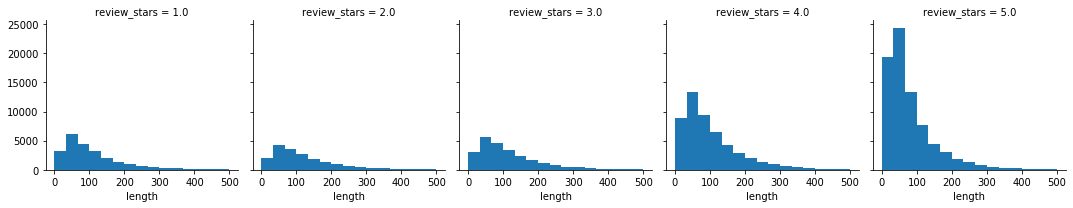

In [ ]:
# dataframe df as input, separated by ratings.
g = sns.FacetGrid(data=df_text_length, col='review_stars')
# Drow histogram, x-axis is word number, y-axis is number of each bin.
g.map(plt.hist, 'length', bins=15, range = (0,500))
# display
plt.show()

- Review length v.s Rating (relative)

As the number of reviews for each rating are different, the previous distribution may not reflect the distribution in each rating clearly. So, we further did visualization in relative way, so that the distribution in each subplot is standalone.

mean = 118.15250830632922


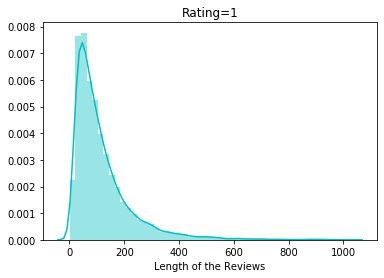

mean = 129.3868747372846


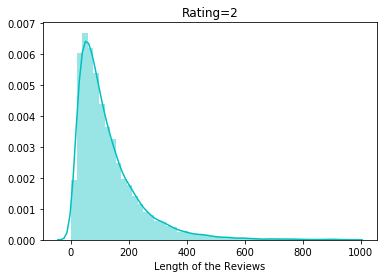

mean = 123.66956244520603


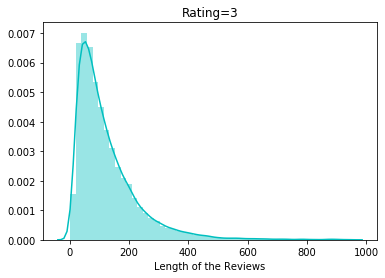

mean = 106.56408775981524


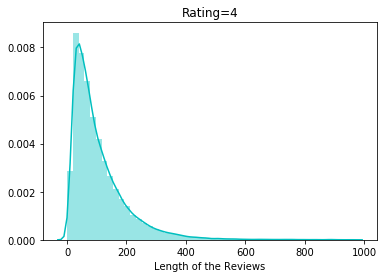

mean = 84.69213589259279


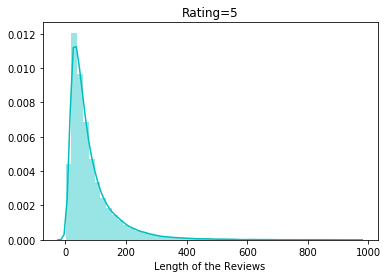

In [ ]:
# Store average length for each rating
average_length_list = []

# Loop each rating
for stars in range(1, 6):
    # Extract the dataframe with this rating
    rating_curr = df_text_length[(df_text_length.review_stars == stars)]
    
    # Plot by taking this sub-df as input
    plot = sns.distplot(rating_curr['length'],label='rating='+str(stars),axlabel='Length of the Reviews',color="c")
    
    # Set title
    plt.title('Rating='+str(stars))
    
    # Save the figure as image
    fig = plot.get_figure()
    fig.savefig('rating_' + str(stars) + '.png')
    
    # Display the average length for each rating
    print ('mean =',np.mean(rating_curr['length']))
    
    # update list
    average_length_list.append(np.mean(rating_curr['length']))
    
    # Display figure
    plt.show()

- Average Length of Each Rating

Based on the previous exploration, we found the average review length for each rating is different.

What's more, the length and rating shows a trends: People tends to write longer reviews when giving low ratings, while they prefer to write less words in reviews when giving high ratings.

As we can see, the average length for 5-star is only 84.69 words, while the average word number is more than 122 for 2-star and 1-star.

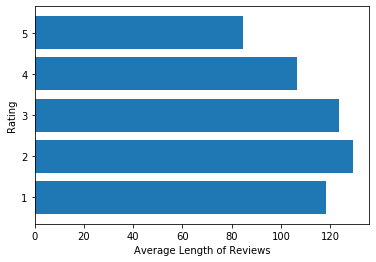

In [ ]:
# There are totally 5 classes of rating, from 1 to 5.
rating_classes = [1,2,3,4,5]

fig, ax = plt.subplots()

# Plot by bar graph
plt.barh(rating_classes, average_length_list)

# Label in x and y-axis
ax.set_xlabel('Average Length of Reviews')
ax.set_ylabel('Rating')

# Save the figure
plt.savefig("average_length.png")

# Display
plt.show()

- Number of Reviews for Each Rating

First, we show the number of reviews for each rating. We found that people tends to write longer reviews as the number of reviews rated 4-star and 5-star contains nearly 66% of the total.

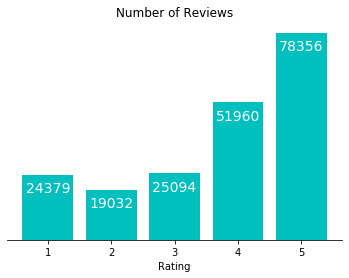

In [ ]:
# Number of reviews of each rating
rating_size = [len(merged[merged.review_stars == 1.0]), len(merged[merged.review_stars == 2.0]), len(merged[merged.review_stars == 3.0]), \
              len(merged[merged.review_stars == 4.0]), len(merged[merged.review_stars == 5.0])]

fig, ax = plt.subplots()

# Draw a bar graph
plt.bar(rating_classes, rating_size, color = 'c')

# Set x-label
ax.set_xlabel('Rating')

# Set title
plt.title('Number of Reviews')

# Write number of reviews in each bar
for i, (rating_a, size_a) in enumerate(zip(rating_classes, rating_size)):
    plt.text(s=str(size_a), x=i+0.65, y=size_a-5000, color="w",
             verticalalignment="center", horizontalalignment="left", size=14)

# Remove the line borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.set_ticks([])

# Save figure
plt.savefig("reviews_size.png")

# Display
plt.show()

#### Popular topics in reviews
We are curious about what are the most significant points that customers care about. What do people say for low rating reviews? What do they like most in their favourite restaurants?

#### Topic Modeling with LDA
To answer these questions, we utilized Latent Dirichlet Allocation (LDA) to do topics modeling, a popular algorithm for topic modeling with excellent implementations in the Python's Gensim package. We want to know what people talk about in good and bad reviews, so that we did topics modeling for good reviews and bad reviews seperately.

In [21]:
def text_process(text):
    """ Remove punctuations and stop words from text
        Args: 
            text(string)
        Returns:
            (list): list of words after processing
    """
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [22]:
def get_docs_for_rating(rating):
    """ Get all reviews under a certain rating
        Args:
            rating(integer)
        Returns:
            (list): review list with each of them a processed word list
    """
    raw_text_list = df_text_length[df_text_length.review_stars == rating].text.tolist()
    return [text_process(doc) for doc in raw_text_list]

In [23]:
# We generated LDA model by ldamodel module in Gensim.
def lda_model(docs):
    """
        Generate LDA model for docs
        Args:
            docs(list): list of documents
        Returns:
            lda_model(LdaModel): LDA model generated by gensim
            dictionary(corpora.Dictionary): a mapping between words and their integer ids
            corpus(list of list): Bag of Word representation of documents 
    """
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(text) for text in docs]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return lda_model, dictionary, corpus

In [24]:
low_rating = 1.0
low_docs = get_docs_for_rating(low_rating)
low_lda_model, low_dictionary, low_corpus = lda_model(low_docs)

NameError: name 'df_text_length' is not defined

In [ ]:
high_rating = 5.0
high_docs = get_docs_for_rating(high_rating)

high_lda_model, high_dictionary, high_corpus = lda_model(high_docs)

We visualized LDA model with pyLDAvis library. It gives us a view of how those topics distribute, and frequency of words in each topic.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(low_lda_model, low_corpus, low_dictionary)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.270895  0.081673       1        1  26.483366
1     -0.229321 -0.017541       2        1  24.414896
7     -0.267830  0.026596       3        1  19.973207
5     -0.176437  0.095346       4        1  15.109533
2      0.010968 -0.433595       5        1   7.400229
3      0.161579  0.030993       6        1   2.250668
4      0.190390  0.053683       7        1   1.243834
0      0.190623  0.053716       8        1   1.163390
8      0.190141  0.054058       9        1   1.053169
6      0.200781  0.055070      10        1   0.907702, topic_info=     Category          Freq          Term         Total  loglift  logprob
10    Default  21122.000000          food  21122.000000  30.0000  30.0000
121   Default  10807.000000            us  10807.000000  29.0000  29.0000
15    Default  12173.000000         place  12173.000000  28.0000  28.0000
82    Default   7647.000000       ordered   7647.000000  27.0000  27.0000
71    Default   9845.000000          like   9845.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
3551  Topic10    111.202995           fat    112.104568   4.6939  -4.7746
1452  Topic10    110.154739        comped    111.056274   4.6939  -4.7841
1348  Topic10    107.420425          Stay    108.321846   4.6937  -4.8092
4138  Topic10    107.278305          Okay    108.179924   4.6936  -4.8105
3281  Topic10    106.603775  specifically    107.505257   4.6936  -4.8168

[415 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
146       2  0.214462        1
146       3  0.082344        1
146       4  0.702993        1
766       3  0.999831       10
6049      6  0.994287       14
...     ...       ...      ...
278       4  0.045031    would
5007      8  0.995301  written
400       1  0.978295    wrong
400       3  0.021750    wrong
1326      1  0.999533    years

[481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 8, 6, 3, 4, 5, 1, 9, 7])

In [ ]:
pyLDAvis.display(pyLDAvis.gensim.prepare(high_lda_model, high_corpus, high_dictionary))



With topics generated from LDA algorithm, we summarized 5 topics from the outputs and extracted the meaningful keywords in those topics for both low rating reviews and high rating reviews.

Topics and keywords from low rating reviews are:

|Topic|	Topic Name|	Keywords|
|------|----|--------|
|1	|Service	|order rude time service manager
|2  |Overall| food place disappointed terrible
|3  |Service| minutes asked tables waitress wait ordered drink
|3	|Environment	|people around dirty old 
|2	|Food	|chicken pizza sauce cheese burger cooked tasted

Topics and keywords from high rating reviews are:

|Topic|	Topic Name	|Keywords
|-----------|----|--------|
|1	|Overall, Service|	food great time service delicious amazing friendly
|2	|Food	|cheese meal experience burger sandwich enjoyed|
|3	|Food	|best fresh pizza salad favorite ingredients
|4	|Environment	|day two home pretty local reasonable
|5	|Food|	Chicken sauce sweet dish flavor cooked authentic perfectly

As from those topics, we concluded that generally customers comment restaurants from 4 perspectives, which are Service, Overall, Food, and Environment. Customers will complain about Food and Service when not satisfied, and will not give a 5-star rating without impression on Service, Food and Environment.

#### Word Cloud

To further support our conclusion on customers' concerns, we used word cloud to visualize the most common words that customers mention in reviews.

Word cloud visualization includes the following steps:

- Get word list for word cloud visualization<br>
- Get stop words to exclude<br>
- Generate a word cloud and show<br>

Firstly, we flattened our previous docs to have two word list for low rating reviews and high rating reviews.

In [ ]:
def flatten_docs(docs):
    return [word for doc in docs for word in doc]

low_rating_words = flatten_docs(low_docs)
high_rating_words = flatten_docs(high_docs)

In [ ]:
print(low_rating_words[:10])

As our purpose was to generate word cloud for low and high rating reviews separately with comparison, and we had already removed stop words from the text, we defined the common words in top 20 frequent words in both reviews as the stop words sent to the word cloud generator.

In [ ]:
def get_common_words(words1, words2, num=20):
    """ Get common words for two word list
        Args:
            words1(list)
            words2(list)
            num(integer): the number of top frequent words to compare
        Returns:
            common_words(list): the common words in top frequent words in both input list
    """
    counter1 = Counter(words1)
    counter2 = Counter(words2)
    freq_words1 = set([word[0] for word in counter1.most_common()[:num]])
    freq_words2 = set([word[0] for word in counter2.most_common()[:num]])
    common_words = list(freq_words1 & freq_words2)
    return common_words

common_words = get_common_words(low_rating_words, high_rating_words)
print('Common words: ', common_words)

With the following two functions, we generated word cloud for both low rating reviews and high rating reviews.

In [ ]:

def generate_word_cloud(words_list, stop_words=[], max_words=100):
    """ Generate a word cloud
        Args:
            words_list(list): list of word as the word cloud data
            stop_words(list): list of stop words to exclude
            max_words(integer): maximum number of word to show on the word cloud image
        Return:
            (WordCloud)
    """
    word_cloud = WordCloud(background_color='white',
                          stopwords=stop_words,
                          max_words=max_words,
                         ).generate(' '.join(words_list))
    return word_cloud

def show_word_cloud(word_cloud):
    """ Show a word cloud
        Args: 
            word_cloud(WordCloud)
    """
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

In [ ]:
low_rating_word_cloud = generate_word_cloud(low_rating_words, stop_words=common_words)
print('Word Cloud for low rating reviews:')
show_word_cloud(low_rating_word_cloud)

In [ ]:
high_rating_word_cloud = generate_word_cloud(high_rating_words, stop_words=common_words)
print('Word Cloud for high rating reviews:')
show_word_cloud(high_rating_word_cloud)

As can be seen from the word clouds, in low rating reviews, customers mention 'order', 'asked', 'table' a lot, which points out their opinions on restaurants' service. While in high rating reviews, positive adjectives like 'delicious', 'great', 'amazing', 'love' occupy a lot of space. From those two word clouds, we could easily notice different emotions and attitudes.

Those two word clouds give some further support on our previous summarization from topic modeling. However, since positive adjectives like 'great' and 'amazing' are quite general, we can not conclude from those adjectives that customers mention which part of the restaurant in the review. Thus, we generate another word cloud which contains only nouns in the text.

We used the word tagging function in nltk library to extract only nouns from the word list.

In [ ]:
def get_nouns_from_words(all_words):
    all_words_with_tag = nltk.pos_tag(all_words)
    return [word[0] for word in all_words_with_tag if word[1] == 'NN']

In [ ]:
low_rating_nouns = get_nouns_from_words(low_rating_words)
high_rating_nouns = get_nouns_from_words(high_rating_words)

In [ ]:
low_rating_nouns_word_cloud = generate_word_cloud(low_rating_nouns)
print('Word Cloud for low rating reviews (with only nouns):')
show_word_cloud(low_rating_nouns_word_cloud)

In [ ]:
high_rating_nouns_word_cloud = generate_word_cloud(high_rating_nouns)
print('Word Cloud for high rating reviews (with only nouns):')
show_word_cloud(high_rating_nouns_word_cloud)

As can be seen from the noun cloud for low rating reviews, customers complain about 'food', 'order', 'place', 'time' and 'service'. In high rating reviews, customers mainly mention 'place', 'food', 'time' and 'order'.

Recalling our previous conclusion on customers' concern, customers care about Service, Food, and Environment. We treated 'place' in the word cloud as a representative of Environment, and the results from word cloud match well with the conclusion from topic modeling. For a 5-star rating, Food and Environment are a must. To avoid a 1-star rating, restaurants should take care of their basic services.

#### Summarization

In data analysis phase, we first had a general idea of whole dataset, and did some research into reviews that we interested in. To summarize, we found out from the dataset that:

- Customers tend to give a high rating. Positive ratings occupy nearly 66% of all reviews.
- Customers write more words when giving low rating reviews.
- Low rating reviews cover more topics on restaurants including Service, Food, and Environment. High rating reviews mainly cover topics like Food and Environment.
- As suggestions to local restaurants, to avoid a low rating, restaurants should make sure they meet the baselines of customers on service and food. To pursue a high rating, restaurants should make some effort on food and environment.

### Clean text

In [44]:
def pipeline(text):
    stops = stopwords.words('english')
    stemmer = PorterStemmer()
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if not word in stops]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

### Create and train model

In [45]:
count_vectorizer = CountVectorizer(min_df=0.2, max_df=0.9, ngram_range=(1, 2), tokenizer=pipeline)
tfidf_vectorizer = TfidfVectorizer(min_df=0.2, max_df=0.9, ngram_range=(1, 2), tokenizer=pipeline)

count_X = count_vectorizer.fit_transform(df_buckets.text)
tfidf_X = tfidf_vectorizer.fit_transform(df_buckets.text)
y = df_buckets.stars

Using test/split

In [46]:
count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(count_X, y, test_size=0.2, random_state=0)
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_X, y, test_size=0.2, random_state=0)

In [47]:
knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(count_X_train, count_y_train)
knn.fit(tfidf_X_train, tfidf_y_train)

print(knn.score(count_X_test, count_y_test))
print(knn.score(tfidf_X_train, tfidf_y_train))

0.48363184479778865
0.5339222620090347


In [48]:
lr = LinearRegression()
lr.fit(count_X_train, count_y_train)
lr.fit(tfidf_X_train, tfidf_y_train)

print(lr.score(count_X_test, count_y_test))
print(lr.score(tfidf_X_train, tfidf_y_train))

-53481.95038466036
0.8623992119862118


Using 10 cross validation

In [49]:
count_knn_scores = cross_val_score(knn, count_X, y, cv=10)
tfidf_knn_scores = cross_val_score(knn, tfidf_X, y, cv=10)
count_lr_scores = cross_val_score(lr, count_X, y, cv=10)
tfidf_lr_scores = cross_val_score(lr, tfidf_X, y, cv=10)

In [50]:
print("{0}, {1}".format(count_knn_scores.mean(), count_knn_scores.std()))
print("{0}, {1}".format(tfidf_knn_scores.mean(), tfidf_knn_scores.std()))
print("{0}, {1}".format(count_lr_scores.mean(), count_lr_scores.std()))
print("{0}, {1}".format(tfidf_lr_scores.mean(), tfidf_lr_scores.std()))

0.5103830287681859, 0.027920896804183106
0.44512282293207484, 0.04663866059157145
-0.10805061329601932, 0.1469817653611127
0.6746622403687108, 0.024021482859729718


The highest performing model is linear regression using tfidf vectorization and porter stemming